In [20]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
figsize=(20, 15)

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [3]:
base_dir = "../data/"

In [4]:
df = pd.read_csv(os.path.join(base_dir, "prepared_df.csv"))

In [5]:
df.head()

,connections,read_percent,write_percent,db_mem_coef,pgpool_cache_coef,read_cost,write_cost,effective,effective_coef
0,80,100,0,0.65,0.433333,29.05,0.0,True,1.085585
1,90,100,0,0.65,0.433333,29.05,0.0,True,1.030422
2,100,100,0,0.65,0.433333,29.05,0.0,True,1.032450
3,150,100,0,0.65,0.433333,29.05,0.0,True,2.429909
4,210,100,0,0.65,0.433333,29.05,0.0,True,2.218325


In [6]:
df.columns

Index(['connections', 'read_percent', 'write_percent', 'db_mem_coef',
       'pgpool_cache_coef', 'read_cost', 'write_cost', 'effective',
       'effective_coef'],
      dtype='object')

In [7]:
X = df.drop(['effective','effective_coef'], axis=1)
y2 = df[['effective','effective_coef']]

In [8]:
X.columns

Index(['connections', 'read_percent', 'write_percent', 'db_mem_coef',
       'pgpool_cache_coef', 'read_cost', 'write_cost'],
      dtype='object')

In [9]:
y2.columns

Index(['effective', 'effective_coef'], dtype='object')

## Работаю с классификацией

#### Определяю функции

In [10]:
def percentages_classes(y, y_train, y_test):
    # Define a dataframe containing frequency percentages
    df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                         y_train.value_counts(normalize=True).mul(100).round(1),
                         y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
    df_perc.columns=['Dataset','Training','Test']
    df_perc = df_perc.T
    
    # Plot frequency percentages barplot
    df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)
    
    # Add the percentages to our plot
    for idx, val in enumerate([*df_perc.index.values]):
        for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
            plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                     y=idx - 0.05,
                     s=f'{percentage}%', 
                     color="black",
                     fontsize=12,
                     fontweight="bold")
    
    plt.legend(title='Personal Loan', loc=(1.01,0.8))
    plt.xlabel('Распределение', fontsize=15)
    plt.title('Распределение целевого значения по тесту и обучению', fontsize=15)
    plt.show()   

In [11]:
import sys
from tqdm.notebook import tqdm
import time
# from tqdm import tqdm if not in notebook
default_stdout= sys.stdout

def grid_fit(model, *args, **kwargs):
    class BarStdout:
        def write(self, text):
            if "totalling" in text and "fits" in text:
                self.bar_size = int(text.split("totalling")[1].split("fits")[0][1:-1])
                self.bar = tqdm(range(self.bar_size))
                self.count = 0
                return
            if "CV" in text and hasattr(self,"bar"):
                self.count += 1
                self.bar.update(n=self.count-self.bar.n)
                if self.count%(self.bar_size//10)==0:
                    time.sleep(0.1)
        def flush(self, text=None):
            pass
    sys.stdout = BarStdout()
    model.verbose = 2
    model.fit(*args, **kwargs)
    sys.stdout = default_stdout
    return model

In [12]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [89]:
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

# Функция оценки качества классификатора
def evaluate_clf(clf, X_train, X_test, y_train, y_test, model_name):
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(
        2, 2, 
        figsize=(10, 8), 
        dpi=100, gridspec_kw=
    {
        'width_ratios': [1,1],
        'height_ratios': [1,2]
    })
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Plot PR curve for test data and display AUC score
    knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_pred_test)
    knn_pr_aps = average_precision_score(y_test, y_pred_test)
    ax4.plot(knn_recall, knn_precision)
    ax4.legend(['PR curve (area = %0.2f)' % knn_pr_aps])
    ax4.set_xlabel('Precision')
    ax4.set_ylabel('Recall')
    ax4.set_title('PR Curve for Test Data (Positive label: 1)')
    
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

#### Работаю с выборкой

In [14]:
y = y2['effective']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

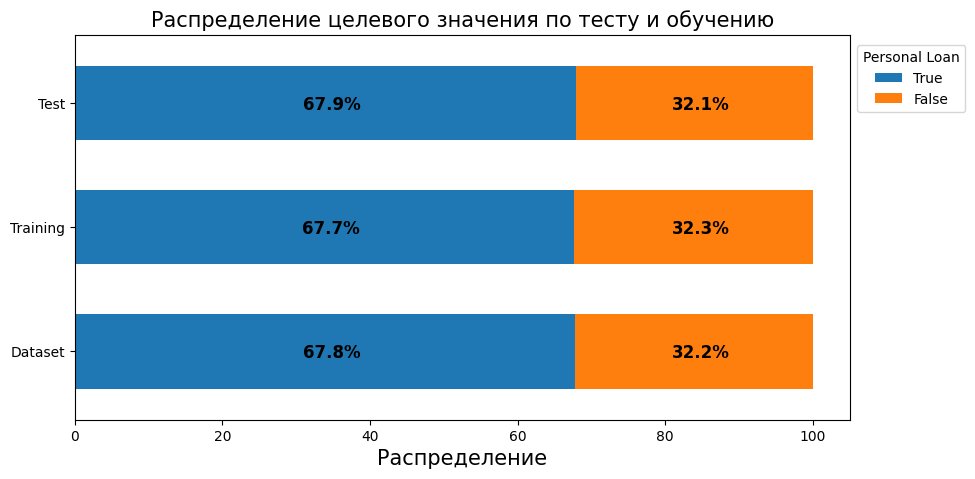

In [16]:
percentages_classes(y, y_train, y_test)

##### DTC

In [62]:
DTC = DecisionTreeClassifier()

DTC_grid = GridSearchCV(
    DTC,
    {
        'max_depth': list(range(1, 200)),
        'max_features': list(range(1, 100)),
        'class_weight': [{0:67, 1:32}],
        'random_state': [47]
    },
    verbose=1,
    n_jobs=5,
    return_train_score=True,
    cv=5,
    scoring=["accuracy", "f1"],
    refit='accuracy'
)
DTC_grid.fit(X_train, y_train)

Fitting 5 folds for each of 19701 candidates, totalling 98505 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'class_weight': [{0: 67, 1: 32}],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'random_state': [47]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1'], verbose=1)

In [63]:
best_depth = DTC_grid.best_estimator_.max_depth # Находим лучшую глубину
best_features = DTC_grid.best_estimator_.max_features # Находим лучшее количество признаков, которые следует учитывать при поиске

DTC = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features, class_weight={False:8, True:2}, random_state=47)
DTC.fit(X_train, y_train)

accuracy_score_DTC = np.mean(y_test.values.ravel() == DTC.predict(X_test))
print("Accuracy of DTC model:",  accuracy_score_DTC)
print("Best f1:", DTC_grid.best_score_)
print("Best model:", DTC_grid.best_estimator_)

Accuracy of DTC model: 0.7222222222222222
Best f1: 0.7188603300557759
Best model: DecisionTreeClassifier(class_weight={0: 67, 1: 32}, max_depth=5, max_features=4,
                       random_state=47)


In [45]:
DTC.predict(X_test[0:10])

array([ True,  True,  True,  True,  True,  True, False,  True, False,
       False])


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.54      0.85      0.66       301
        True       0.90      0.66      0.76       631

    accuracy                           0.72       932
   macro avg       0.72      0.75      0.71       932
weighted avg       0.79      0.72      0.73       932


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.54      0.81      0.65        75
        True       0.89      0.68      0.77       159

    accuracy                           0.72       234
   macro avg       0.71      0.75      0.71       234
weighted avg       0.78      0.72      0.73       234



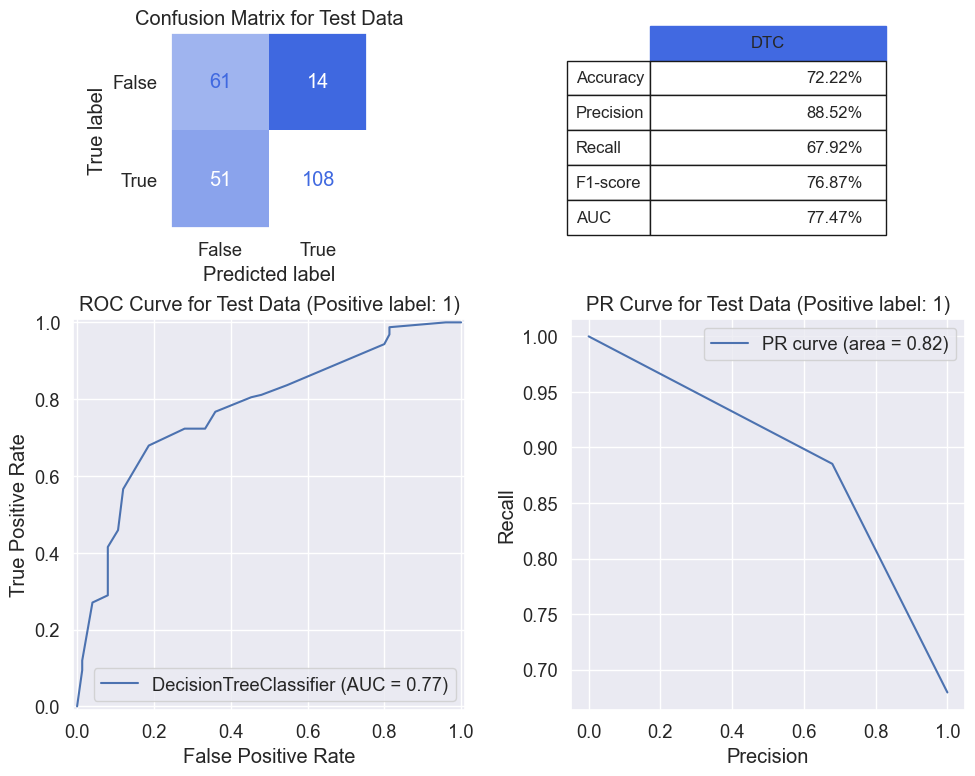

In [90]:
evaluate_clf(DTC, X_train, X_test, y_train, y_test, 'DTC')

##### KNN

In [36]:
KNN = KNeighborsClassifier()

KNN_grid = GridSearchCV(
    KNN,
    {
        'n_neighbors': list(range(1, 50)),
        'weights': ['uniform', 'distance'],
        'leaf_size': list(range(1, 50)),
        'algorithm': ['ball_tree', 'kd_tree'],
    },
    verbose=1,
    return_train_score=True,
    cv=5,
    scoring=["accuracy", "f1"],
    refit='f1',
    n_jobs=8
)
KNN_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9604 candidates, totalling 48020 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             refit='f1', return_train_score=True, scoring=['accuracy', 'f1'],
             verbose=1)

In [37]:
best_n_neighbors = KNN_grid.best_estimator_.n_neighbors
best_weights = KNN_grid.best_estimator_.weights
best_leaf_size = KNN_grid.best_estimator_.leaf_size
best_algorithm = KNN_grid.best_estimator_.algorithm

KNN = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, leaf_size=best_leaf_size, algorithm=best_algorithm)
KNN.fit(X_train, y_train)

accuracy_score_KNN = np.mean(y_test.values.ravel() == KNN.predict(X_test))
print("Accuracy of DTC model:",  accuracy_score_KNN)
print("Best f1:", KNN_grid.best_score_)
print("Best model:", KNN_grid.best_estimator_)

Accuracy of DTC model: 0.6837606837606838
Best f1: 0.7998329775540005
Best model: KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=49)


##### RidgeClassifier

In [60]:
from sklearn.linear_model import RidgeClassifier

In [61]:
RC = RidgeClassifier(alpha=0.2, class_weight={0:67, 1:32})
RC.fit(X_train, y_train)

accuracy_score_RC = np.mean(y_test.values.ravel() == RC.predict(X_test))
print("Accuracy of RC model:",  accuracy_score_RC)
# print("Best f1:", RC_grid.best_score_)
# print("Best model:", RC_grid.best_estimator_)

Accuracy of RC model: 0.6068376068376068


##### SGDClassifier

In [21]:
from sklearn.linear_model import SGDClassifier

In [41]:
SGDC = SGDClassifier(alpha=0.2, class_weight={0:6, 1:4})
SGDC.fit(X_train, y_train)

accuracy_score_SGDC = np.mean(y_test.values.ravel() == SGDC.predict(X_test))
print("Accuracy of RC model:",  accuracy_score_SGDC)

Accuracy of RC model: 0.6495726495726496


##### LSVC

In [43]:
from sklearn.svm import LinearSVC

In [47]:
LSVC = LinearSVC(dual=True, class_weight={0:6, 1:4})
LSVC.fit(X_train, y_train)

accuracy_score_LSVC = np.mean(y_test.values.ravel() == LSVC.predict(X_test))
print("Accuracy of RC model:",  accuracy_score_LSVC)

Accuracy of RC model: 0.5982905982905983


/home/lenow/.cache/pypoetry/virtualenvs/eda-test-unit4pgbench-VYr1lpxO-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


##### SVC

In [50]:
from sklearn.svm import SVC as SVClass

In [52]:
SVC = SVClass(C=0.6, class_weight={0:6, 1:4})
SVC.fit(X_train, y_train)

accuracy_score_SVC = np.mean(y_test.values.ravel() == SVC.predict(X_test))
print("Accuracy of RC model:",  accuracy_score_SVC)

Accuracy of RC model: 0.6837606837606838


##### GPC

In [53]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [56]:
GPC = GaussianProcessClassifier(max_iter_predict=200, n_restarts_optimizer=2)
GPC.fit(X_train, y_train)

accuracy_score_GPC = np.mean(y_test.values.ravel() == GPC.predict(X_test))
print("Accuracy of GPC model:",  accuracy_score_GPC)

Accuracy of GPC model: 0.6410256410256411


##### GNB

In [58]:
from sklearn.naive_bayes import GaussianNB

In [59]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

accuracy_score_GNB = np.mean(y_test.values.ravel() == GNB.predict(X_test))
print("Accuracy of GNB model:",  accuracy_score_GNB)

Accuracy of GNB model: 0.6239316239316239


##### GradientBoostingClassifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
GBC = GradientBoostingClassifier(max_depth=5, max_features='log2', max_leaf_nodes=8)
GBC.fit(X_train, y_train)

accuracy_score_GBC = np.mean(y_test.values.ravel() == GBC.predict(X_test))
print("Accuracy of GBC model:",  accuracy_score_GBC)

Accuracy of GBC model: 0.7478632478632479



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.86      0.67      0.76       301
        True       0.86      0.95      0.90       631

    accuracy                           0.86       932
   macro avg       0.86      0.81      0.83       932
weighted avg       0.86      0.86      0.85       932


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.64      0.49      0.56        75
        True       0.78      0.87      0.82       159

    accuracy                           0.75       234
   macro avg       0.71      0.68      0.69       234
weighted avg       0.74      0.75      0.74       234



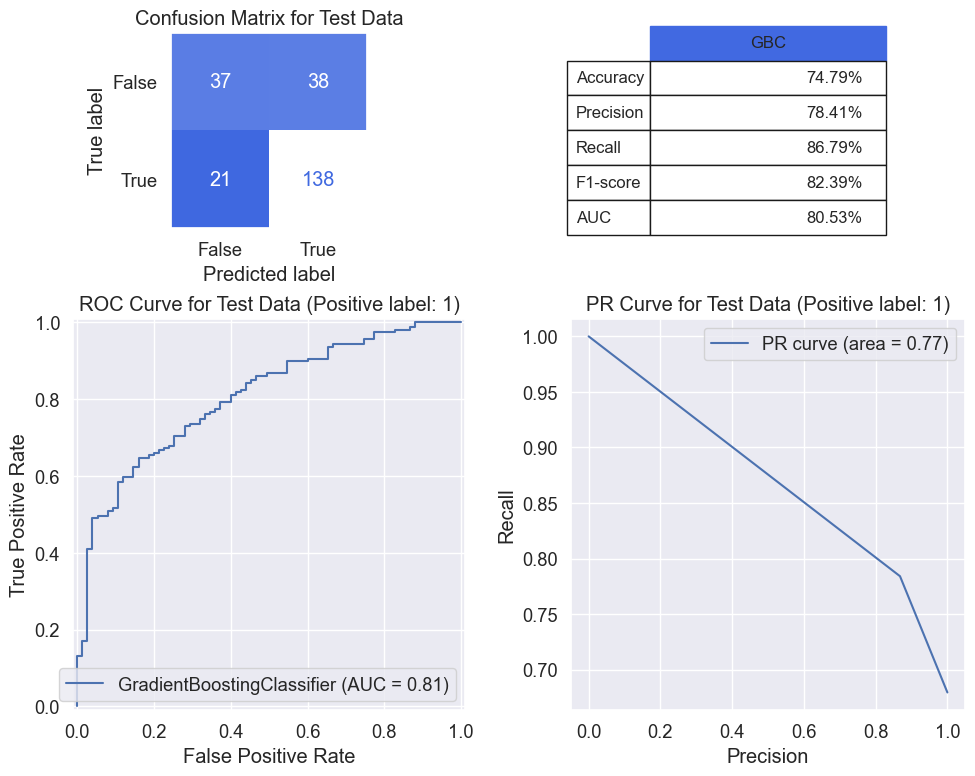

In [91]:
evaluate_clf(GBC, X_train, X_test, y_train, y_test, 'GBC')

##### HistGradientBoostingClassifier

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [57]:
HGBC = HistGradientBoostingClassifier(
    max_depth=10,
    max_leaf_nodes=8,
    class_weight={0:67, 1:32})
HGBC.fit(X_train, y_train)

accuracy_score_HGBC = np.mean(y_test.values.ravel() == HGBC.predict(X_test))
print("Accuracy of HGBC model:",  accuracy_score_HGBC)

Accuracy of HGBC model: 0.7521367521367521



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.67      0.89      0.76       301
        True       0.94      0.79      0.86       631

    accuracy                           0.82       932
   macro avg       0.80      0.84      0.81       932
weighted avg       0.85      0.82      0.82       932


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.58      0.79      0.67        75
        True       0.88      0.74      0.80       159

    accuracy                           0.75       234
   macro avg       0.73      0.76      0.74       234
weighted avg       0.78      0.75      0.76       234



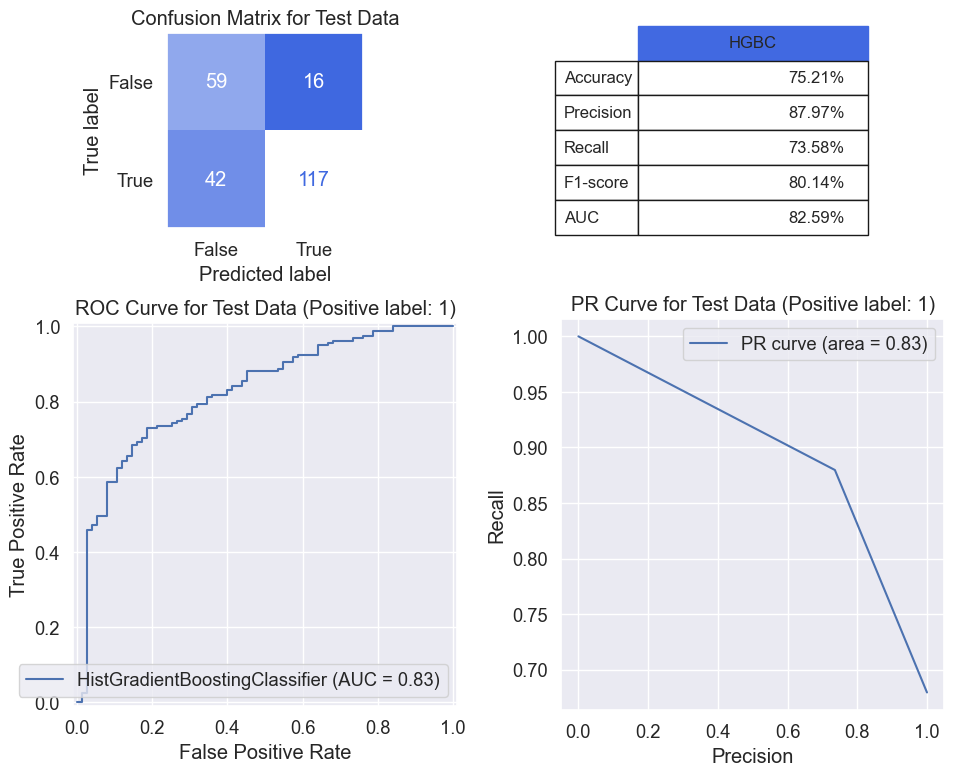

In [92]:
evaluate_clf(HGBC, X_train, X_test, y_train, y_test, 'HGBC')